<a href="https://colab.research.google.com/github/JyotiRawat29/MastersThesis/blob/main/cnn_lstm_seprate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as f
from torch import nn
import scipy.io as sio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive
import tensorflow as tf
from tensorflow import summary
import matplotlib.pyplot as plt
from google.colab import drive


In [ ]:
writer = SummaryWriter()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()
#load the ECG file
src_dataset = sio.loadmat('/content/drive/MyDrive/ECG2(withDA).mat')
#load the labels
label=pd.read_csv('/content/drive/MyDrive/label.csv',header=None)

In [ ]:
#print(src_dataset)
testdata = src_dataset['ECG'] # use the key for data here
X=testdata['Data']

In [ ]:
X

array([[array([[ 0.01601611,  0.01644181,  0.01690118, ...,  0.00294596,
         0.00106469, -0.00456328],
       [-0.11488888, -0.12236424, -0.12891141, ..., -0.03361464,
        -0.03650065, -0.03900078],
       [-0.04865461, -0.06793926, -0.0696586 , ..., -0.30155847,
        -0.33376829, -0.34922594],
       ...,
       [ 0.11534132,  0.10149052,  0.08043098, ..., -0.12040478,
        -0.10044553, -0.07588876],
       [-0.04609605, -0.03321084, -0.01958534, ..., -0.01756399,
        -0.01391065, -0.01017211],
       [ 0.03929655,  0.01265927, -0.00714671, ...,  0.02241839,
         0.03816335,  0.05258733]])]], dtype=object)

In [ ]:
X=np.array(X[0])
X = np.vstack(X[:,]).astype(np.float)
X=torch.from_numpy(X)

In [ ]:
label=np.array(label, dtype=object)
label=np.array(label)
label= np.vstack(label[:,]).astype(np.float)


In [ ]:
enc = LabelEncoder()
Y_enc = enc.fit_transform(label)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
 Y = torch.tensor(Y_enc)

In [ ]:
torch.set_printoptions(threshold=5000)

In [ ]:
def create_datasets(X, Y):
    enc = LabelEncoder()
    Y_enc = enc.fit_transform(Y)
    print("len of X and Y is",X.shape,Y.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y) 
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, stratify = Y_train) 
    #squeeze labelled data to make it 1 dimension array
    Y_train=torch.squeeze(Y_train)
    Y_valid=torch.squeeze(Y_valid)
    Y_test=torch.squeeze(Y_test)
    print("X_train, X_valid, X_test shape before list comprehension",X_train.shape, X_valid.shape, X_test.shape)
    print("X_train, X_valid, X_test dtype before list comprehension",X_train.dtype, X_valid.dtype, X_test.dtype)
    print("Y_train, Y_valid, Y_test dtype before list comprehension",Y_train.dtype, Y_valid.dtype, Y_test.dtype)
    #the tensors created have dtype float64 but the models have dtypes float32 and its easier to change dtypes of the tensors instead of a model
    X_train, X_valid, X_test = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid,X_test)]
    Y_train, Y_valid,Y_test = [torch.tensor(arr, dtype=torch.long) for arr in (Y_train, Y_valid,Y_test)]
    print("X_train, X_valid, X_test shape after list comprehension",X_train.shape, X_valid.shape, X_test.shape)
    print("X_train, X_valid, X_test dtype before list comprehension",X_train.dtype, X_valid.dtype, X_test.dtype)
    print("Y_train, Y_valid, Y_test dtype before list comprehension",Y_train.dtype, Y_valid.dtype, Y_test.dtype)
    #convert training and testing data into Tensor Dataset
    train_ds = TensorDataset(X_train, Y_train)
    valid_ds = TensorDataset(X_valid, Y_valid)
    test_ds = TensorDataset(X_test,Y_test)
    print("train_ds, valid_ds, test_ds length of datasets respectively",len(train_ds), len(valid_ds), len(test_ds))
    return train_ds, valid_ds,test_ds, enc

In [ ]:
def create_loaders(train_ds, valid_ds,test_ds, bs, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=True, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=True, num_workers=jobs)
    print("lenth of data loaders train_dl, valid_dl, test_dl",len(train_dl), len(valid_dl), len(test_dl))
    return train_dl, valid_dl, test_dl

In [ ]:
def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [ ]:
class CNN(nn.Module):
  def __init__(self, input_dim,output_channels, kernel_size, stride=1):
    super().__init__()
    self.input_dim = input_dim
    self.output_channels = output_channels
    self.cnn = nn.Conv1d(input_dim,output_channels, kernel_size=1)
    self.fc = nn.Linear(hidden_dim, output_cnn)

  def forward(self,x):
    out = self.cnn(x)
    print("output shape before fc",out.size)
    out = self.fc(out[:,-1:])
    print("shape of output", out.size())
    return out


In [ ]:
class LSTM(nn.Module):
  def __init__(self, output_cnn, hidden_dim_lstm, layer_dim, output_dim):
    super().__init__()
    self.output_cnn = output_cnn
    self.hidden_dim_lstm = hidden_dim_lstm
    self.layer_dim = layer_dim
    self.lstm = nn.LSTM(output_cnn, hidden_dim_lstm, layer_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim_lstm, output_dim)
    

  def forward(self,x):
    h0, c0 = self.init_hidden(x)
    out, (hn, cn) = self.lstm(x, (h0,c0))
    print(f'shape of out before fc_LSTM is {out.size()}')
    out = self.fc(out[:,-1, :])
    print(f'shape of out after fc_LSTM is {out.size()}')
    print(f'final output is {out} ')
    return out
  
  def init_hidden(self, x):
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim_lstm)
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim_lstm)
    #print("h0 size in init function",h0.size())
    return [t.to(device) for t in (h0, c0)]


NameError: ignored

In [ ]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,output_channels=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cnn = nn.Conv1d(input_dim,output_channels, kernel_size=1)
        self.fc = nn.Linear(hidden_dim, output_cnn)
        self.lstm = nn.LSTM(output_cnn, hidden_dim, layer_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        #self.softmax = nn.Softmax(dim=1)
        self.batch_size = None
        self.hidden = None
        
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out1 = self.cnn(x)
        #print("output_cnn",out1)
        #print("output_cnn_size",out1.size())
        out2 = self.fc(out1[:,-1:])
        #print("out_size fc_cnn",out2.size())
        #print("h0,c0 size", h0.size(),c0.size())
        out, (hn, cn) = self.lstm(out2, (h0, c0))
        #print("output shape lstm",out.size())
        #output's dimension has been reduced
        out = self.fc1(out[:, -1, :])
        #print("output size fc_lstm",out.size())
        #print("final output",out)
        #out = self.softmax(out)
        #print(out)
        return out


    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        #print("h0 size in init function",h0.size())
        return [t.to(device) for t in (h0, c0)]


NameError: ignored

In [ ]:
train_ds, val_ds, test_data, enc = create_datasets(X, Y)

len of X and Y is torch.Size([1273, 4000]) torch.Size([1273])
X_train, X_valid, X_test shape before list comprehension torch.Size([763, 4000]) torch.Size([255, 4000]) torch.Size([255, 4000])
X_train, X_valid, X_test dtype before list comprehension torch.float64 torch.float64 torch.float64
Y_train, Y_valid, Y_test dtype before list comprehension torch.int64 torch.int64 torch.int64
X_train, X_valid, X_test shape after list comprehension torch.Size([763, 4000]) torch.Size([255, 4000]) torch.Size([255, 4000])
X_train, X_valid, X_test dtype before list comprehension torch.float32 torch.float32 torch.float32
Y_train, Y_valid, Y_test dtype before list comprehension torch.int64 torch.int64 torch.int64
train_ds, valid_ds, test_ds length of datasets respectively 763 255 255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [ ]:
bs = 32
train_dl, valid_dl,test_data = create_loaders(train_ds, val_ds,test_data, bs, jobs=cpu_count())

lenth of data loaders train_dl, valid_dl, test_dl 24 8 8


In [ ]:


input_dim = 1
hidden_dim = 4000
output_cnn = 100
layer_dim = 1
output_dim = 3
seq_dim = 4000
lr = 0.001
output_channels = 4000
hidden_dim_lstm = 100

n_epochs = 101
iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 100, 0




In [ ]:
model = CNN(input_dim, output_channels, kernel_size =1)
model = model.to(device)


In [ ]:
model_lstm = LSTM(output_cnn,hidden_dim_lstm,layer_dim,output_dim)
model_lstm = model_lstm.to(device)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
model = LSTMClassifier(input_dim,hidden_dim,layer_dim,output_dim)
model = model.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

NameError: ignored

In [ ]:
print(model)

CNN(
  (cnn): Conv1d(1, 4000, kernel_size=(1,), stride=(1,))
  (fc): Linear(in_features=4000, out_features=100, bias=True)
)


In [ ]:
import copy

In [ ]:
history = dict(train =[], val = [])
best_loss = 1
best_model_wts = copy.deepcopy(model.state_dict())
for epochs in range(1, n_epochs+1):
  train_losses = []
  val_losses = []
  for x_batch,y_batch in train_dl:
    print(f'training loop :: epoch is {epochs}')
    model.train()
    print(f'x_batch size is {x_batch.size()}')
    x_batch = x_batch.unsqueeze(1)
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    features_cnn_x = model(x_batch)
    feature_cnn_y = y_batch
    features_cnn_x = features_cnn_x.to(device)
    feature_cnn_y = feature_cnn_y.to(device)
    model_lstm.train()
    out = model_lstm(features_cnn_x)
    loss = criteria(out,y_batch)
    print("loss is ",loss)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  with torch.no_grad():
    for x_val,y_val in valid_dl:
      print(f'validation loop :: epoch is {epochs}')
      model.eval()
      x_val =x_val.unsqueeze(1)
      optimizer.zero_grad()
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      features_cnn_val_x = model(x_val)
      feature_cnn_val_y = y_val
      features_cnn_val_x = features_cnn_val_x.to(device)
      feature_cnn_val_y = feature_cnn_val_y.to(device)
      model_lstm.eval()
      out_val = model_lstm(features_cnn_val_x)
      loss_val = criteria(out_val,y_val)
      print("loss is (validation)",loss_val)
      val_losses.append(loss_val.item())
          
  train_loss = np.mean(train_losses)
  val_loss = np.mean(val_losses)

  history['train'].append(train_loss)
  history['val'].append(val_loss)     
  print(f'Epoch {epochs} : trainloss {train_loss} : val loss {val_loss}')
        #writer.add_scalars('Training vs validation Loss',
        #                   {'Training' : loss},
          #                  epochs *len( history['train']))

writer.flush()
writer.add_graph(model,x_batch)
writer.close()


        




Streaming output truncated to the last 5000 lines.
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801],
        [ 0.2150, -0.3590,  0.0801]]) 
loss is (validation) tensor(1.0627)
validation loop :: epoch is 97
output shape before fc torch.Size([31, 4000, 4000])
shape of output torch.Size([31, 1, 100])
shape of out before fc_LSTM is torch.Size([31, 1, 100])
shape of out after fc_LSTM i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  del sys.path[0]


output shape before fc torch.Size([27, 4000, 4000])
shape of output torch.Size([27, 1, 100])
output shape before fc torch.Size([27, 4000, 4000])
shape of output torch.Size([27, 1, 100])


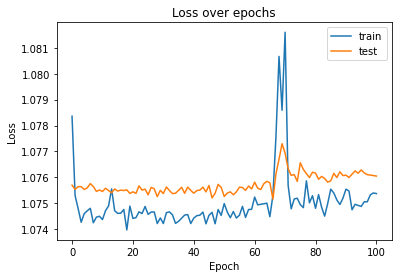

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over epochs')
#plt.show()
plt.savefig('Loss_over_epochs.png')

In [ ]:
history = dict(train =[], val = [])
best_loss = 1
best_model_wts = copy.deepcopy(model.state_dict())
for epochs in range(1, n_epochs+1):
  train_losses = []
  val_losses = []
  if epochs in range(3):
    for x_batch,y_batch in train_dl:
      print(f'training loop :: epoch is {epochs}')
      model.train()
      print(f'x_batch size is {x_batch.size()}')
      x_batch = x_batch.unsqueeze(1)
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      out = model(x_batch)
      print("out is ",out)
      print("y_batch is ", y_batch)
      loss = criteria(out,y_batch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    #if i % 5 == 0:
     # print("iteration %d, epochs %d,loss = %.4f" %(i,epochs,loss.item()))
    with torch.no_grad():
      for x_val,y_val in valid_dl:
        print(f'validation loop :: epoch is {epochs}')
        model.eval()
        x_val =x_val.unsqueeze(1)
        optimizer.zero_grad()
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        out = model(x_val)
        print("out_val is :", out)
        print("y_val is ",y_val)
        loss = criteria(out,y_val)
        val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
    # best_loss = val_lossesbest_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Epoch {epochs} : trainloss {train_loss} : val loss {val_loss}')
    #writer.add_scalars('Training vs validation Loss',
     #                   {'Training' : loss},
      #                  epochs *len( history['train']))

  writer.flush()
  writer.add_graph(model,x_batch)
  writer.close()

  model.load_state_dict(best_model_wts)


training loop :: epoch is 1
x_batch size is torch.Size([32, 4000])
out is  tensor([[-0.0196,  0.0070, -0.0059],
        [-0.0199,  0.0067, -0.0053],
        [-0.0197,  0.0068, -0.0053],
        [-0.0196,  0.0068, -0.0057],
        [-0.0196,  0.0072, -0.0054],
        [-0.0199,  0.0064, -0.0051],
        [-0.0191,  0.0068, -0.0056],
        [-0.0192,  0.0075, -0.0062],
        [-0.0198,  0.0068, -0.0055],
        [-0.0197,  0.0068, -0.0053],
        [-0.0196,  0.0065, -0.0053],
        [-0.0196,  0.0069, -0.0055],
        [-0.0198,  0.0068, -0.0055],
        [-0.0198,  0.0068, -0.0057],
        [-0.0196,  0.0069, -0.0054],
        [-0.0196,  0.0067, -0.0052],
        [-0.0197,  0.0067, -0.0056],
        [-0.0198,  0.0068, -0.0054],
        [-0.0191,  0.0079, -0.0054],
        [-0.0199,  0.0073, -0.0055],
        [-0.0196,  0.0070, -0.0057],
        [-0.0196,  0.0069, -0.0055],
        [-0.0195,  0.0068, -0.0053],
        [-0.0197,  0.0070, -0.0055],
        [-0.0197,  0.0069, -0.0053],


KeyboardInterrupt: ignored

In [ ]:
history = dict(train =[], val = [])
best_loss = 1
best_model_wts = copy.deepcopy(model.state_dict())
for epochs in range(1, n_epochs+1):
  train_losses = []
  val_losses = []
  for x_batch,y_batch in train_dl:
    print(f'training loop :: epoch is {epochs}')
    model.train()
    x_batch = x_batch.unsqueeze(1)
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    out = model(x_batch)
    loss = criteria(out,y_batch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    #if i % 5 == 0:
     # print("iteration %d, epochs %d,loss = %.4f" %(i,epochs,loss.item()))
  with torch.no_grad():
    for x_val,y_val in valid_dl:
      print(f'validation loop :: epoch is {epochs}')
      model.eval()
      x_val =x_val.unsqueeze(1)
      optimizer.zero_grad()
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      out = model(x_val)
      loss = criteria(out,y_val)
      val_losses.append(loss.item())
  
  train_loss = np.mean(train_losses)
  val_loss = np.mean(val_losses)

  history['train'].append(train_loss)
  history['val'].append(val_loss)

  #if val_loss < best_loss:
   # best_loss = val_lossesbest_model_wts = copy.deepcopy(model.state_dict())
  
  print(f'Epoch {epochs} : trainloss {train_loss} : val loss {val_loss}')
  writer.add_scalars('Training vs validation Loss',
                       {'Training' : loss},
                       epochs *len( history['train']))

writer.flush()
writer.add_graph(model,x_batch)
writer.close()

model.load_state_dict(best_model_wts)


training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1
training loop :: epoch is 1


KeyboardInterrupt: ignored

In [ ]:
model.state_dict()

OrderedDict([('cnn.weight', tensor([[[3.5070]]])),
             ('cnn.bias', tensor([0.1062])),
             ('fc.weight',
              tensor([[-2.6621e-02, -4.4411e-02, -5.3176e-02,  ...,  2.9087e-02,
                        6.2047e-02,  5.7984e-02],
                      [ 4.1843e-02,  6.2076e-02,  8.6345e-02,  ...,  5.6072e-02,
                        3.6729e-02,  4.8194e-02],
                      [-3.2800e-03,  8.6702e-03,  7.6439e-03,  ..., -2.1715e-02,
                       -1.4851e-02, -1.7354e-02],
                      ...,
                      [ 3.7215e-02, -1.0306e-03, -1.4038e-03,  ...,  1.2648e-02,
                       -5.9738e-03,  1.5882e-02],
                      [ 6.3928e-02,  6.3521e-02,  7.7119e-02,  ...,  2.4966e-05,
                        1.2192e-02,  2.2303e-02],
                      [ 9.6691e-02,  9.9952e-02,  1.0562e-01,  ...,  6.1575e-02,
                        4.7147e-02,  3.2291e-02]])),
             ('fc.bias',
              tensor([-5.9753e-03, -

In [ ]:
history['val']

[4.2702222019433975,
 4.262030273675919,
 4.289130687713623,
 4.352687656879425,
 4.2523631155490875,
 4.42069411277771,
 4.468575805425644,
 4.481773883104324,
 4.502141624689102,
 4.500783443450928,
 4.477127432823181,
 4.619614869356155,
 4.5841231644153595,
 4.487133055925369,
 4.609535127878189,
 4.547390282154083,
 4.675490468740463,
 4.658600091934204,
 4.606040865182877,
 4.68226033449173,
 4.645402163267136,
 4.684078067541122,
 4.875272274017334,
 4.8126852214336395,
 4.811688721179962,
 4.905931293964386,
 4.88066041469574,
 5.049883097410202,
 5.037159353494644,
 4.924504667520523,
 5.015293061733246,
 5.017097055912018,
 4.890299946069717,
 4.981059193611145,
 5.157070815563202,
 5.393358677625656,
 5.184930711984634,
 5.5330159068107605,
 5.607106864452362,
 5.410694748163223,
 5.463030934333801,
 5.489333540201187,
 5.646244645118713,
 5.670216590166092,
 5.72143429517746,
 5.755019903182983,
 5.741957008838654,
 5.803092896938324,
 5.828267216682434,
 5.837239325046539,

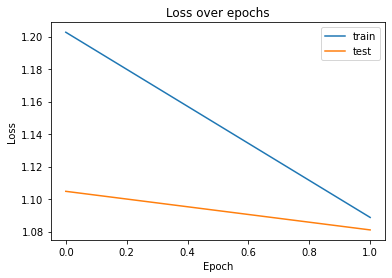

In [ ]:

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over epochs')
#plt.show()
plt.savefig('Loss_over_epochs.png')


In [ ]:
for epochs in range(1, n_epochs+1):
  train_losses = []
  for i, (x_batch,y_batch) in enumerate(train_dl):
    
    print("i=", i)
    model.train()
    x_batch = x_batch.unsqueeze(1)
    #print("x_batch size",x_batch.size())
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    out = model(x_batch)
    #print(out.size())
    #print(y_batch.size())
    loss = criteria(out,y_batch)
    #print("loss",loss)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if i % 5 == 0:
      print("iteration %d, epochs %d,loss = %.4f" %(i,epochs,loss.item()))
    total = 0.0
  correct = 0.0
  val_losses = []
  with torch.no_grad():
    for x_val,y_val in valid_dl:
      model.eval()
      x_val =x_val.unsqueeze(1)
      optimizer.zero_grad()
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      out = model(x_val)
      y_val = torch.unsqueeze(y_val,0)
      preds = F.log_softmax(out, dim=1).argmax(dim = 1)
      total = total + y_val.size(1)
      correct += (preds == y_val).sum().item()
    acc = correct/total
    print(f'accuracy is {acc:2.2%} epoch is  {epochs}')
    acc1 =[]
    acc1.append(acc)

  writer.add_scalars('Training vs validation Loss',
                       {'Training' : loss},
                       epochs *len(train_dl)+i)

writer.flush()




i= 0
iteration 0, epochs 1,loss = 0.1079
i= 1
i= 2
i= 3
i= 4
i= 5
iteration 5, epochs 1,loss = 0.2214
i= 6
i= 7
i= 8
i= 9
i= 10
iteration 10, epochs 1,loss = 0.1924
i= 11
i= 12
i= 13
i= 14
i= 15
iteration 15, epochs 1,loss = 0.1320
i= 16
i= 17
i= 18
i= 19
i= 20
iteration 20, epochs 1,loss = 0.1200
i= 21
i= 22
i= 23
accuracy is 53.73% epoch is  1
i= 0
iteration 0, epochs 2,loss = 0.1098
i= 1
i= 2
i= 3
i= 4
i= 5
iteration 5, epochs 2,loss = 0.0163
i= 6
i= 7
i= 8
i= 9
i= 10
iteration 10, epochs 2,loss = 0.1062
i= 11
i= 12
i= 13
i= 14
i= 15
iteration 15, epochs 2,loss = 0.2478
i= 16
i= 17
i= 18
i= 19
i= 20
iteration 20, epochs 2,loss = 0.1413
i= 21
i= 22
i= 23
accuracy is 51.37% epoch is  2
i= 0
iteration 0, epochs 3,loss = 0.0797
i= 1
i= 2
i= 3
i= 4
i= 5
iteration 5, epochs 3,loss = 0.1313
i= 6
i= 7
i= 8
i= 9
i= 10
iteration 10, epochs 3,loss = 0.3884
i= 11
i= 12
i= 13
i= 14
i= 15
iteration 15, epochs 3,loss = 0.1313
i= 16
i= 17
i= 18
i= 19
i= 20
iteration 20, epochs 3,loss = 0.1082
i= 21

In [ ]:
acc

0.47058823529411764

In [ ]:
for i, (x_batch,y_batch) in enumerate(train_dl):
    #x_batch = torch.tensor(x_batch).flatten()
    print("i=", i)
    model.train()
    x_batch = x_batch.unsqueeze(1)
    print("x_batch size",x_batch.size())
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    out = model(x_batch)
    print(out.size())
    print(y_batch.size())
    loss = criteria(out,y_batch)
    print("loss",loss)
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
      print("iteration %d, loss = %.4f" %(i,loss.item()))
    #writer.add_scalars('Training vs validation Loss',{'Training' : loss},1 *len(train_dl)+i)
    


  

i= 0
x_batch size torch.Size([32, 1, 4000])
h0 size in init function torch.Size([1, 32, 4000])
output_cnn tensor([[[-0.6327, -0.6333, -0.6338,  ..., -0.6301, -0.6318, -0.6331]],

        [[-0.6492, -0.6489, -0.6481,  ..., -0.6364, -0.6334, -0.6260]],

        [[-0.6092, -0.6108, -0.6125,  ..., -0.6303, -0.6301, -0.6298]],

        ...,

        [[-0.6226, -0.6224, -0.6224,  ..., -0.6381, -0.6397, -0.6419]],

        [[-0.6313, -0.6316, -0.6317,  ..., -0.6298, -0.6294, -0.6296]],

        [[-0.6183, -0.6186, -0.6184,  ..., -0.6402, -0.6398, -0.6393]]],
       grad_fn=<SqueezeBackward1>)
output_cnn_size torch.Size([32, 1, 4000])
out_size fc_cnn torch.Size([32, 1, 100])
ho,co size torch.Size([1, 32, 4000]) torch.Size([1, 32, 4000])
output shape lstm torch.Size([32, 1, 4000])
output size fc_lstm torch.Size([32, 3])
final output tensor([[ 0.0053,  0.0145, -0.0059],
        [ 0.0052,  0.0146, -0.0057],
        [ 0.0054,  0.0145, -0.0061],
        [ 0.0056,  0.0146, -0.0057],
        [ 0.0054

In [ ]:
total = 0.0
correct = 0.0
for x_val,y_val in valid_dl:
   model.eval()
   #x_val, y_val = [t for t in (x_val, y_val)]
   #print(x_val)
   x_val =x_val.unsqueeze(1)
   #print("X_val size", x_val.size())
   optimizer.zero_grad()
   x_val = x_val.to(device)
   y_val = y_val.to(device)
   #print("x_val",x_val.size())
   out = model(x_val)
   y_val = torch.unsqueeze(y_val,0)
   print("y_val", y_val)
   print("y_val",y_val.size())
   preds = F.log_softmax(out, dim=1).argmax(dim = 1)
   print("predictions", preds)
   print("y_val size(0)", y_val.size(0))
   total = total + y_val.size(1)
   correct += (preds == y_val).sum().item()
   print("total is =",total)
   print("number of correct values are =", correct)
   acc = correct/total
   print(f'accuracy is {acc:2.2%}')

h0 size in init function torch.Size([1, 32, 4000])
output size fc_lstm torch.Size([32, 3])
y_val tensor([[0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2,
         1, 0, 2, 0, 1, 1, 1, 2]])
y_val torch.Size([1, 32])
predictions tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
y_val size(0) 1
total is = 32.0
number of correct values are = 15.0
accuracy is 46.88%
h0 size in init function torch.Size([1, 32, 4000])
output size fc_lstm torch.Size([32, 3])
y_val tensor([[2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1,
         0, 2, 1, 2, 1, 0, 2, 0]])
y_val torch.Size([1, 32])
predictions tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
y_val size(0) 1
total is = 64.0
number of correct values are = 28.0
accuracy is 43.75%
h0 size in init function torch.Size([1, 32, 4000])
output size fc_lstm torch.Size([32, 3])
y_val t

In [ ]:
writer = SummaryWriter('runs')